In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

from utils.funs import count_outliers
from utils.symmetry_scores import get_scores

from transformers import RobertaModel, AutoModelForMaskedLM

/opt/homebrew/Caskroom/miniconda/base/envs/attention-geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dir = '../../../_data/fig-symmetry-language-models/ROBERTA-query-key.pkl'

if os.path.isfile(dir):
    with open(dir, 'rb') as file:
        models = pickle.load(file)
else: models = {}

In [4]:
path = ["encoder.layer[", "].attention.self.query.weight", "].attention.self.key.weight"]

'ROBERTA base (l = 24, d = 1024, h = 16 ; 125M parameters)'
dh = 64
l = 12
d = 768
h = d // dh

model = RobertaModel.from_pretrained('roberta-base')
score_List= get_scores(d, l, h, dh, model, path)
models['ROBERTA-base'] = [l, d, h, dh, score_List]

'ROBERTA large (l = 24, d = 1024, h = 16 ; 355M parameters)'
dh = 64
l = 23
d = 1024
h = d // dh

model = RobertaModel.from_pretrained('roberta-large')
score_List= get_scores(d, l, h, dh, model, path)
models['ROBERTA-large'] = [l, d, h, dh, score_List]

path = ["roberta.encoder.layer[", "].attention.self.query.weight", "].attention.self.key.weight"]

'DistillROBERTA base (l = 6, d = 768, h = 12 ; 82.2M parameters)'
dh = 64
l = 6
d = 768
h = d // dh

model = AutoModelForMaskedLM.from_pretrained("distilbert/distilroberta-base")
score_List= get_scores(d, l, h, dh, model, path)
models['distill-ROBERTA'] = [l, d, h, dh, score_List]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at distilbert/distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model

In [5]:
'save'
with open(dir, 'wb') as file:
    pickle.dump(models, file)

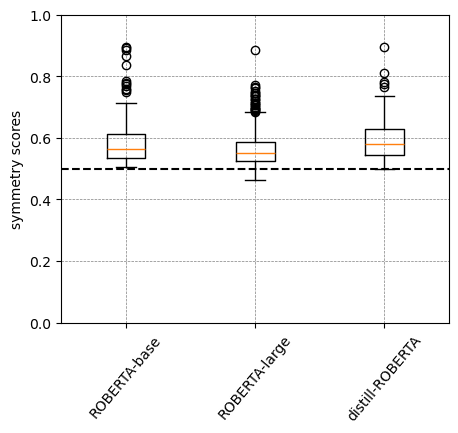

In [6]:
## boxplot visualization

with open(dir, 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-1].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(5,4))

plt.boxplot(SList)

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylabel('symmetry scores')
plt.xticks(np.arange(1,len(names)+1),names)
plt.xticks(rotation=50)
plt.ylim(0,1)
plt.axhline(y=.5,color='k',linestyle='dashed')

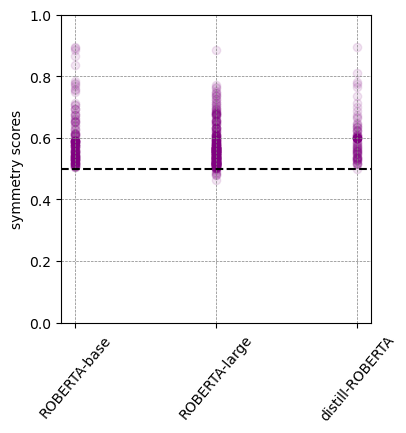

In [7]:
## mean and scatter visualization

with open(dir, 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-1].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(4,4))

for i, model in enumerate(SList):
    
    plt.scatter(i*np.ones(SList[i].size),(SList[i].flatten()),color='purple',alpha=.1)
    plt.scatter(i,(SList[i].flatten()).mean(),color='purple')

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylabel('symmetry scores')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation=50)
plt.ylim(0,1)
plt.axhline(y=.5,color='k',linestyle='dashed')

(array([0, 1, 2]),
 [Text(0, 0, 'ROBERTA-base'),
  Text(1, 0, 'ROBERTA-large'),
  Text(2, 0, 'distill-ROBERTA')])

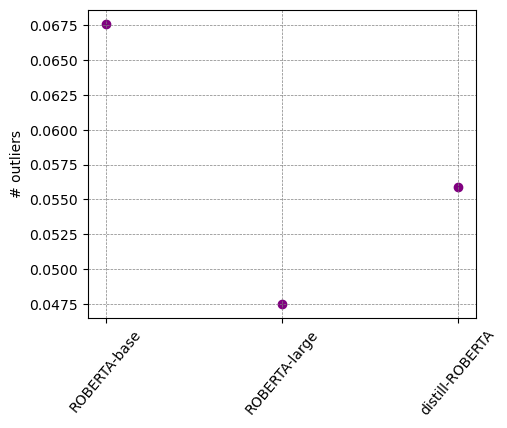

In [8]:
## percentage of outliers visualization

with open(dir, 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-1].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(5,4))

for i, model in enumerate(SList):
    
    outliers = count_outliers(SList[i].flatten())
    plt.scatter(i, outliers.sum() / SList[i].size, color='purple')

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylabel('# outliers')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation = 50)

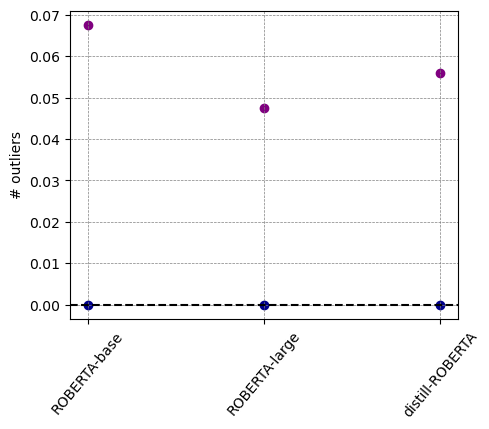

In [9]:
## percentage of outliers visualization

with open(dir, 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-1].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(5,4))

for i, model in enumerate(SList):
    
    outliers = count_outliers(SList[i].flatten())
    plt.scatter(i, outliers[outliers < .5].sum() / SList[i].size, color='darkblue')
    plt.scatter(i, outliers[outliers > .5].sum() / SList[i].size, color='purple')

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylabel('# outliers')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation = 50)
plt.axhline(y = .0,color='k',linestyle='dashed')